In [ ]:
!pip install botorch

In [ ]:
# imports

import os
import time
import copy
import warnings
from abc import ABC, abstractmethod

import torch
import matplotlib.pyplot as plt
%matplotlib inline

# GPyTorch imports
from gpytorch.mlls import ExactMarginalLogLikelihood

# BoTorch imports
from botorch.acquisition import AnalyticAcquisitionFunction, ExpectedImprovement
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.fit import fit_gpytorch_mll
from botorch.models import SingleTaskGP
from botorch.models.transforms import Log, Standardize
from botorch.optim import optimize_acqf
from botorch.test_functions import Ackley
from botorch.test_functions import Rosenbrock
from botorch.test_functions import Branin
from botorch.test_functions.synthetic import Hartmann
from botorch.test_functions.synthetic import Beale
from botorch.test_functions.synthetic import Bukin
from botorch.test_functions.synthetic import Powell
from botorch.test_functions.synthetic import ConstrainedGramacy
#from botorch.test_functions import GramacyLee
from botorch.utils import standardize
from botorch.utils.sampling import draw_sobol_samples

import torch

In [ ]:
warnings.filterwarnings("ignore")
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
tkwargs = {
    "device": device,
    "dtype": torch.double,
}
SMOKE_TEST = os.environ.get("SMOKE_TEST")

## Cost Model and GP Setup

In [ ]:
class CostModel(torch.nn.Module, ABC):
    """
    Simple abstract class for a cost model.
    """

    @abstractmethod
    def forward(self, X):
        pass


class CostModelGP(CostModel):
    """
    A basic cost model that assumes the cost is positive.
    It models the log cost to guarantee positive cost predictions.
    """

    def __init__(self, X, Y_cost):
        assert torch.all(Y_cost > 0)
        super().__init__()
        gp = SingleTaskGP(train_X=X, train_Y=Y_cost, outcome_transform=Log())
        mll = ExactMarginalLogLikelihood(likelihood=gp.likelihood, model=gp)
        fit_gpytorch_mll(mll)
        self.gp = gp

    def forward(self, X):
        return torch.exp(self.gp(X).mean)

In [ ]:
DIM = 2

In [ ]:
def measure_gap(initial_minimum, min_observation, global_minimum):
  numerator = initial_minimum - min_observation
  denominator = initial_minimum - global_minimum
  if denominator == 0:
    return 1
  return numerator / denominator


def synthetic_objective_with_cost(x):
    dim = DIM
    f = ConstrainedGramacy(dim)
    fx = f(x).unsqueeze(1)
    quad_cost = 200 * (1.1 - x[:, 0] - x[:, 1]) ** 2  # synthetic cost is quadratric
    exp_cost = torch.exp(-x[:, 0] - x[:, 1]) + 1  # Adding 1 ensures positivity
    trig_cost = torch.sin(x[:, 0])**2 + torch.cos(x[:, 1])**2
    cx = trig_cost.unsqueeze(1) + 1
    return fx, cx

# Generate training data
dim = DIM
num = 14
bounds = torch.ones(2, dim, **tkwargs)
bounds[0, :] = -5.
bounds[1, :] = 10.
train_X = draw_sobol_samples(bounds=bounds, n=num, q=1, seed=111).squeeze(1)
train_Y, cost_Y = synthetic_objective_with_cost(train_X)
testfn = Ackley(dim)
global_minimizer = testfn.optimizers[0]
global_minimum = standardize(testfn(global_minimizer))

# Fit GP to data
train_Y = standardize(train_Y)
initial_minimum = train_Y.min() # Extract initial minimum from GP
gp = SingleTaskGP(train_X=train_X, train_Y=train_Y)
mll = ExactMarginalLogLikelihood(likelihood=gp.likelihood, model=gp)
fit_gpytorch_mll(mll)

# Fit cost model to data
cost_model_gp = CostModelGP(train_X, cost_Y.reshape(num, 1))

In [ ]:
linspaces = [torch.linspace(bounds[0, 0], bounds[1, 0], 100, **tkwargs) for d in range(DIM)]

# Create a grid for DIM-dimensional space
meshgrid = torch.meshgrid(*linspaces, indexing="ij")  # indexing="ij" for Cartesian indexing

# Stack to form a DIM-dimensional tensor of shape (n_points^DIM, DIM)
X_preds = torch.stack(meshgrid, dim=-1).view(-1, DIM)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))


# Plot GP
Y_preds = gp.posterior(X_preds)
Y_mean = Y_preds.mean.squeeze().detach().numpy()
Y_var = Y_preds.variance.squeeze().detach().numpy()
Y_std = torch.sqrt(Y_preds.variance).squeeze().detach().numpy()

cost_Y_preds = cost_model_gp.gp.posterior(X_preds)
cost_Y_mean = cost_Y_preds.mean.squeeze().detach().numpy()
cost_Y_var = cost_Y_preds.variance.squeeze().detach().numpy()
cost_Y_std = torch.sqrt(cost_Y_preds.variance).squeeze().detach().numpy()
axes[0].plot(X_preds, Y_preds.mean.detach().numpy(), "r")
axes[0].plot(train_X, train_Y, "k^")
axes[0].fill_between(
    X_preds.numpy()[:, 0], Y_mean - 2 * Y_std, Y_mean + 2 * Y_std, color="m", alpha=0.5
)
axes[0].set_title("Gaussian Process Model")
axes[0].set_ylabel("Objective Value")

# Plot Cost Model
cost_preds = cost_model_gp(X_preds)
axes[1].plot(X_preds, cost_preds.detach().numpy())
axes[1].plot(train_X, cost_Y, "kv")
axes[1].fill_between(
    X_preds.numpy()[:, 0], cost_Y_mean - 2 * cost_Y_std, cost_Y_mean + 2 * cost_Y_std, color="m", alpha=0.5
)
axes[1].set_title("Cost Model")
axes[1].set_ylabel("Cost of Evaluation")

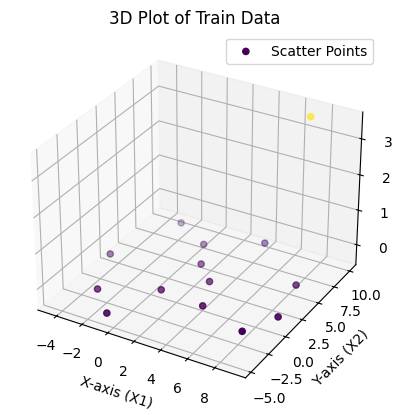

In [ ]:
# 3-D plot when necessary
ax = plt.axes(projection='3d')

# Extract x, y, z from train_X and train_Y
xline = train_X[:, 0].numpy()  # First column of train_X
yline = train_X[:, 1].numpy()  # Second column of train_X
zline = train_Y.squeeze(1).numpy()        # Corresponding train_Y values

# Plot the line connecting the points
#ax.plot3D(xline, yline, zline, 'gray', label='3D Line')

# Scatter the individual points
ax.scatter3D(xline, yline, zline, c=zline, cmap='viridis', label='Scatter Points')

# Add labels and title
ax.set_xlabel('X-axis (X1)')
ax.set_ylabel('Y-axis (X2)')
ax.set_zlabel('Z-axis (Objective Value)')
ax.set_title('3D Plot of Train Data')
ax.legend()

# Show the plot
plt.show()

## EIpu and One-Step Myopic Optimization

In [ ]:
class ExpectedImprovementWithCost(AnalyticAcquisitionFunction):
    """
    This is the acquisition function EI(x) / c(x) ^ alpha, where alpha is a decay
    factor that reduces or increases the emphasis of the cost model c(x).
    """

    def __init__(self, model, best_f, cost_model, alpha=1):
        super().__init__(model=model)
        self.model = model
        self.cost_model = cost_model
        self.ei = ExpectedImprovement(model=model, best_f=best_f)
        self.alpha = alpha

    def forward(self, X):
        cost = self.cost_model(X).reshape(-1)
        return self.ei(X) / torch.pow(cost, self.alpha)


In [ ]:
def bayesian_optimization_with_cost(
    init_X, init_Y, init_C, objective, cost_model_class, budget, bounds, initial_size, tkwargs, is_random=False, global_minimum=float('inf')
):
    """
    Bayesian optimization loop with cost model.
    """
    train_X = init_X
    train_Y = init_Y
    cost_Y = init_C
    accum_cost = 0.
    train_Y_unstd = train_Y.clone()

    for i in range(budget):
        alpha = (budget - i - 1) / (budget - 1)

        # Train GP model for objective
        # train_Y_unstd = train_Y.clone()
        train_Y_flip = -1 * standardize(train_Y)
        gp = SingleTaskGP(train_X=train_X, train_Y=train_Y_flip)
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_mll(mll)

        cost_model_gp = cost_model_class(train_X, cost_Y.reshape(cost_Y.shape[0], 1))


        # Acquisition function: Expected Improvement with cost
        fmax = torch.max(train_Y_flip)
        eipu = ExpectedImprovementWithCost(
            model=gp,
            cost_model=cost_model_gp,
            best_f=fmax,
            alpha=alpha,
        )

        # Optimize acquisition function to find next query point
        if not is_random:
          new_x, acq_value = optimize_acqf(
              acq_function=eipu,
              bounds=bounds,
              q=1,
              num_restarts=5,
              raw_samples=1024,
          )
        else:
          # Could be off for multi dimension
          lower_bounds = bounds[0, :]
          upper_bounds = bounds[1, :]
          d = len(bounds[0, :])
          new_x = lower_bounds + (upper_bounds - lower_bounds) * torch.rand(1, d)

        new_y, cost_y = objective(new_x.view(1, -1))
        accum_cost += cost_y

        # Update training data
        train_X = torch.cat([train_X, new_x])
        train_Y_unstd = torch.cat([train_Y_unstd, torch.tensor([new_y], **tkwargs).unsqueeze(1)])
        # cost_Y = torch.cat([cost_Y, torch.tensor([cost_y], **tkwargs).unsqueeze(1)])
        cost_Y = torch.cat([cost_Y, cost_y])

        train_Y = standardize(train_Y_unstd)
        global_minimum = min(global_minimum, new_y)


    # Calculate cumulative minimum of objective values (minimization) and cumulative costs
    # costs_eipu = cost_Y[initial_size-1:, 0]
    costs_eipu = cost_Y[initial_size-1:]
    results_ei_cost, _ = torch.cummin(train_Y_unstd, dim=0)
    results_ei_cost = results_ei_cost[initial_size-1:]
    times_ei_cost = torch.cumsum(costs_eipu, dim=0)

    return train_X, results_ei_cost, times_ei_cost, accum_cost, global_minimum


bounds = torch.tensor([[0] * dim, [1] * dim], **tkwargs)
initial_size = 4
train_X = draw_sobol_samples(bounds=bounds, n=initial_size, q=1).squeeze(1)
train_Y, cost_Y = synthetic_objective_with_cost(train_X)
initial_minimum = train_Y.min()

results = bayesian_optimization_with_cost(
    init_X=train_X,
    init_Y=train_Y,
    init_C=cost_Y,
    objective=synthetic_objective_with_cost,
    cost_model_class=CostModelGP,
    budget=10,
    bounds=bounds,
    initial_size = initial_size,
    tkwargs=tkwargs,
    # is_random=True
)


In [ ]:
observed_cummin = results[1]
print(train_Y)
gaps = torch.empty_like(observed_cummin)
print(initial_minimum)
print(observed_cummin)
for i, mini in enumerate(observed_cummin):
  gaps[i] = measure_gap(initial_minimum, mini, global_minimum)

tensor([[ 9.4740],
        [12.3890],
        [15.3507],
        [ 5.8340]], dtype=torch.float64)
tensor(5.8340, dtype=torch.float64)
tensor([[5.8340],
        [5.8340],
        [5.8340],
        [5.7662],
        [4.4022],
        [3.8231],
        [3.8231],
        [3.8231],
        [3.8231],
        [3.8231],
        [3.8231]], dtype=torch.float64)


In [ ]:
results[-1]

tensor([[0.2037]], dtype=torch.float64)

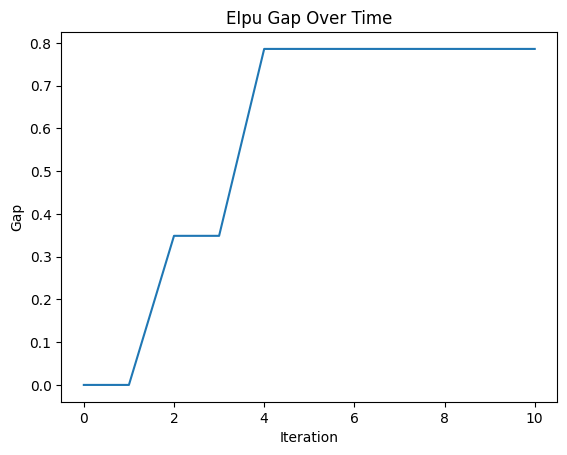

In [ ]:
plt.plot(gaps)
plt.xlabel("Iteration")
plt.ylabel("Gap")
plt.title("EIpu Gap Over Time")
plt.show()

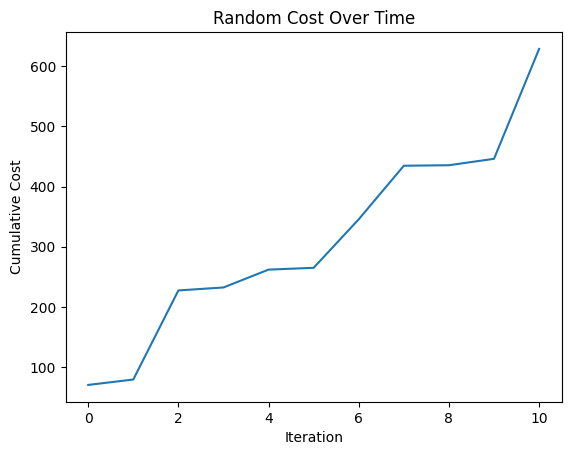

In [ ]:
plt.plot(results[2])
plt.xlabel("Iteration")
plt.ylabel("Cumulative Cost")
plt.title("Random Cost Over Time")
plt.show()

In [ ]:
results[2][-1]

tensor([628.4233], dtype=torch.float64)

In [ ]:
def simulate_bo_loop(n, objective, cost_model_class, budget, bounds, initial_size, tkwargs):

    gap_runs = []  # Store the gaps for each run
    global_minimum = float('inf')  # Or a known global minimum if available
    avg_time = []
    torch.manual_seed(0)
    for _ in range(n):
        # randomize initial observations
        train_X = draw_sobol_samples(bounds=bounds, n=initial_size, q=1).squeeze(1)
        train_Y, cost_Y = synthetic_objective_with_cost(train_X)
        print(cost_Y)
        print(train_X)
        print(train_Y)
        initial_minimum = train_Y.min()
        # Run the Bayesian optimization loop
        train_X, results_ei_cost, times_ei_cost, accum_cost, global_minimum = bayesian_optimization_with_cost(
            init_X=train_X,
            init_Y=train_Y,
            init_C=cost_Y,
            objective=objective,
            cost_model_class=cost_model_class,
            budget=budget,
            bounds=bounds,
            initial_size=initial_size,
            tkwargs=tkwargs,
            global_minimum=global_minimum
        )

        # Calculate gaps for this run
        observed_cummin = results_ei_cost
        gaps = torch.empty_like(observed_cummin)
        for i, mini in enumerate(observed_cummin):
            gaps[i] = measure_gap(initial_minimum, mini, global_minimum)

        gap_runs.append(gaps)
        avg_time.append(times_ei_cost)

    # Stack the gap runs and times to compute statistics across runs
    gap_runs_tensor = torch.stack(gap_runs)
    avg_time_tensor = torch.mean(torch.stack(avg_time), dim=0)

    # Calculate the mean and standard deviation of the gap across runs
    expected_gap = torch.mean(gap_runs_tensor, dim=0)
    gap_std = torch.std(gap_runs_tensor, dim=0)

    # Calculate confidence intervals (e.g., 95% CI)
    confidence_interval = 1.96 * gap_std / torch.sqrt(torch.tensor(n, dtype=torch.float32))

    return expected_gap, avg_time_tensor, confidence_interval, gap_std, gap_runs

# Parameters for simulation
n = 5  # Number of simulations
budget = 20
initial_size = 10

# Prepare the initial data
bounds = torch.tensor([[0] * dim, [1] * dim], **tkwargs)

# Run the simulation to calculate the expected gap
expected_gap, times_ei_cost, confidence_interva, std_dev, gap_runs = simulate_bo_loop(
    n=n,
    objective=synthetic_objective_with_cost,
    cost_model_class=CostModelGP,
    budget=budget,
    bounds=bounds,
    initial_size=initial_size,
    tkwargs=tkwargs,
)

tensor([[1.8974],
        [2.2978],
        [2.0856],
        [1.9476],
        [1.3612],
        [2.4140],
        [2.0462],
        [2.0661],
        [1.5634],
        [2.2891]], dtype=torch.float64)
tensor([[0.4751, 0.5925],
        [0.5788, 0.0371],
        [0.9507, 0.8623],
        [0.1205, 0.2614],
        [0.2149, 0.9742],
        [0.8538, 0.4035],
        [0.7421, 0.6955],
        [0.3142, 0.1725],
        [0.2579, 0.7871],
        [0.6858, 0.3411]], dtype=torch.float64)
tensor([[-1.4942],
        [-2.9323],
        [ 2.8482],
        [ 1.5056],
        [ 3.2286],
        [ 1.3407],
        [ 1.0610],
        [-0.4258],
        [-1.7924],
        [ 3.4688]], dtype=torch.float64)
tensor([[1.3934],
        [2.5727],
        [2.0164],
        [1.9567],
        [1.6862],
        [2.2972],
        [2.0795],
        [1.9731],
        [1.7617],
        [2.4677]], dtype=torch.float64)
tensor([[0.0961, 0.9023],
        [0.8725, 0.1184],
        [0.6034, 0.5857],
        [0.3661, 0.4269]

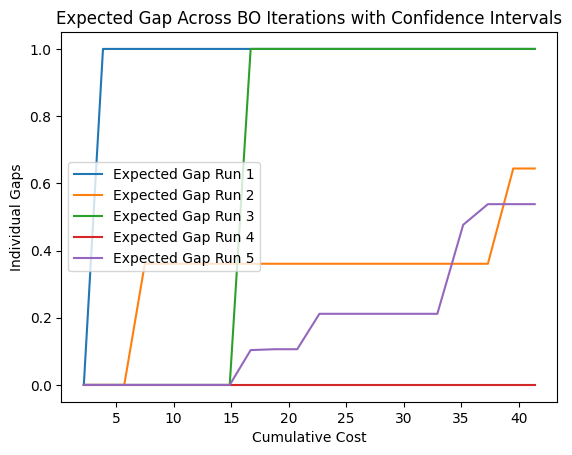

In [ ]:
for i, gap_run in enumerate(gap_runs):
    plt.plot(times_ei_cost, gap_run, label=f"Expected Gap Run {i+1}")

plt.xlabel("Cumulative Cost")
plt.ylabel("Individual Gaps")
plt.title("Expected Gap Across BO Iterations with Confidence Intervals")
plt.legend()
plt.show()

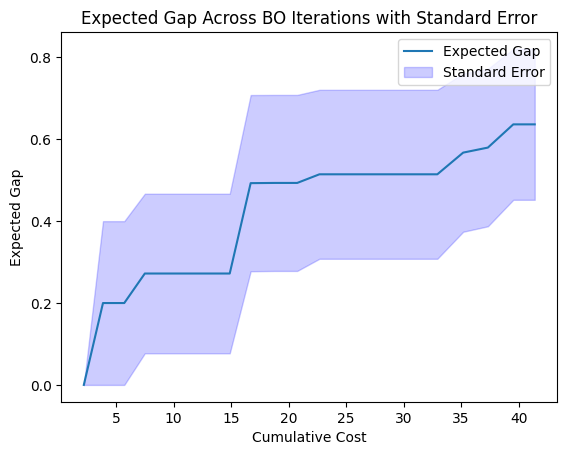

tensor([[0.0000],
        [0.2000],
        [0.2000],
        [0.2721],
        [0.2721],
        [0.2721],
        [0.2721],
        [0.2721],
        [0.4929],
        [0.4934],
        [0.4934],
        [0.5145],
        [0.5145],
        [0.5145],
        [0.5145],
        [0.5145],
        [0.5145],
        [0.5674],
        [0.5797],
        [0.6364],
        [0.6364]], dtype=torch.float64)


In [ ]:
# Plot the expected gap with confidence intervals
plt.plot(times_ei_cost, expected_gap, label="Expected Gap")
y1 = (expected_gap - std_dev / (n ** (1/2))).view(-1).tolist()
y2 = (expected_gap + std_dev / (n ** (1/2))).view(-1).tolist()
plt.fill_between(times_ei_cost.squeeze(1), y1, y2,
                 color='b', alpha=0.2, label="Standard Error")
plt.xlabel("Cumulative Cost")
plt.ylabel("Expected Gap")
plt.title("Expected Gap Across BO Iterations with Standard Error")
plt.legend()
plt.show()

print(expected_gap)

In [ ]:
print("times_ei_cost", times_ei_cost.squeeze(1))
print("expected_gap", expected_gap.squeeze(1))
print("std_dev", std_dev.squeeze(1))

times_ei_cost tensor([ 2.1877,  3.8542,  5.7053,  7.4928,  9.3727, 11.1779, 13.0072, 14.8776,
        16.6979, 18.7954, 20.7468, 22.6789, 24.6464, 26.7148, 28.7753, 30.8287,
        32.9334, 35.1811, 37.3315, 39.5388, 41.4047], dtype=torch.float64)
expected_gap tensor([0.0000, 0.2000, 0.2000, 0.2721, 0.2721, 0.2721, 0.2721, 0.2721, 0.4929,
        0.4934, 0.4934, 0.5145, 0.5145, 0.5145, 0.5145, 0.5145, 0.5145, 0.5674,
        0.5797, 0.6364, 0.6364], dtype=torch.float64)
std_dev tensor([0.0000, 0.4472, 0.4472, 0.4358, 0.4358, 0.4358, 0.4358, 0.4358, 0.4812,
        0.4807, 0.4807, 0.4614, 0.4614, 0.4614, 0.4614, 0.4614, 0.4614, 0.4322,
        0.4299, 0.4121, 0.4121], dtype=torch.float64)


In [ ]:
print(times_ei_cost)
print(expected_gap)

tensor([[  55.1043],
        [ 209.2571],
        [ 352.8323],
        [ 459.6023],
        [ 596.7100],
        [ 746.7171],
        [ 876.7087],
        [ 960.3409],
        [1094.3131],
        [1284.4954],
        [1427.1701]], dtype=torch.float64)
tensor([[0.0000],
        [0.4708],
        [0.8563],
        [0.8563],
        [0.8887],
        [0.9947],
        [0.9995],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]], dtype=torch.float64)


In [ ]:
fig, axes = plt.subplots(figsize=(8, 4))

train_X, results_ei_cost, times_ei_cost = results

axes.plot(times_ei_cost, results_ei_cost, "--b", marker="^")
axes.set_xlabel("Cumulative Training Time (s)")
axes.set_ylabel("Loss")
axes.set_title("Loss over time")

plt.tight_layout()


## Knowledge Gradient

In [ ]:
from botorch.acquisition import MCAcquisitionFunction
from botorch.acquisition.knowledge_gradient import qKnowledgeGradient
from botorch.utils.transforms import concatenate_pending_points

class KGWithCost(MCAcquisitionFunction):
    def __init__(self, model, cost_model, best_f, alpha=1, num_fantasies=64):
        super().__init__(model=model)
        self.cost_model = cost_model
        self.best_f = best_f
        self.alpha = alpha
        self.num_fantasies = num_fantasies

    def forward(self, X):
        # Compute the KG acquisition value
        # Note: In BoTorch, the KG acquisition function handles the lookahead
        # We'll need to adjust it to account for the cost

        # Get the posterior of the model at X
        posterior = self.model.posterior(X)
        mean = posterior.mean.squeeze(-1)
        variance = posterior.variance.squeeze(-1)
        std = variance.sqrt()

        # Expected Improvement
        u = (mean - self.best_f) / std
        phi = torch.distributions.Normal(0, 1).cdf(u)
        ei = std * (u * phi + torch.distributions.Normal(0, 1).log_prob(u).exp())

        # Cost prediction
        cost = self.cost_model(X).reshape(-1)

        # Adjust the utility by the cost
        utility = ei / torch.pow(cost, self.alpha)

        return utility

from botorch.acquisition.knowledge_gradient import qKnowledgeGradient
from botorch.optim.optimize import optimize_acqf

def get_kg_with_cost_acqf(model, cost_model, best_f, bounds, alpha=1, num_fantasies=64):
    # Initialize the qKnowledgeGradient acquisition function
    kg_acqf = qKnowledgeGradient(
        model=model,
        num_fantasies=num_fantasies,
        current_value=best_f,
    )

    # Define a custom utility function
    def utility(samples, X):
        # Compute the expected improvement with cost
        posterior_mean = samples.mean(dim=0)
        posterior_std = samples.std(dim=0)
        u = (posterior_mean - best_f) / posterior_std
        phi = torch.distributions.Normal(0, 1).cdf(u)
        ei = posterior_std * (u * phi + torch.distributions.Normal(0, 1).log_prob(u).exp())
        cost = cost_model(X).reshape(-1)
        utility = ei / torch.pow(cost, alpha)
        return utility

    # Set the utility function in the KG acquisition function
    kg_acqf.set_X_pending(None)  # Clear any pending points
    kg_acqf.utility = utility

    return kg_acqf

def bayesian_optimization_with_cost(
    init_X, init_Y, init_C, objective, cost_model_class, budget, bounds, initial_size, tkwargs, is_random=False, global_minimum=float('inf')
):
    train_X = init_X
    train_Y = init_Y
    cost_Y = init_C
    accum_cost = 0.
    train_Y_unstd = train_Y.clone()

    for i in range(budget):
        alpha = (budget - i - 1) / (budget - 1)

        # Train GP model for objective
        gp = SingleTaskGP(train_X=train_X, train_Y=train_Y)
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_mll(mll)

        # Train cost model
        cost_model_gp = cost_model_class(train_X, cost_Y.reshape(cost_Y.shape[0], 1))

        # Best observed value so far
        best_f = train_Y.max().item()

        # Get the KG acquisition function with cost
        kg_acqf = get_kg_with_cost_acqf(
            model=gp,
            cost_model=cost_model_gp,
            best_f=best_f,
            bounds=bounds,
            alpha=alpha,
            num_fantasies=64,  # Adjust as needed
        )

        # Optimize the acquisition function to find the next point
        new_x, _ = optimize_acqf(
            acq_function=kg_acqf,
            bounds=bounds,
            q=1,
            num_restarts=5,
            raw_samples=1024,
        )

        # Evaluate the objective and cost at the new point
        new_y, cost_y = objective(new_x.view(1, -1))
        accum_cost += cost_y
        # print(new_y)
        # print(new_y.shape)
        # print(train_Y)
        # print(train_Y.shape)

        # Update training data
        train_X = torch.cat([train_X, new_x])
        train_Y = torch.cat([train_Y, new_y])
        cost_Y = torch.cat([cost_Y, cost_y])

        global_minimum = min(global_minimum, new_y.item())

    # Calculate cumulative minimum of objective values and cumulative costs
    results_ei_cost, _ = torch.cummin(train_Y, dim=0)
    results_ei_cost = results_ei_cost[initial_size-1:]
    times_ei_cost = torch.cumsum(cost_Y[initial_size-1:], dim=0)

    return train_X, results_ei_cost, times_ei_cost, accum_cost, global_minimum


# Minimal parameters for a single test run of Bayesian Optimization with cost
single_test_budget = 10  # Only one iteration to check the setup
initial_size = 4
dim = 2
tkwargs = {"dtype": torch.double}
bounds = torch.tensor([[0] * dim, [1] * dim], **tkwargs)

# Generate initial data
train_X = draw_sobol_samples(bounds=bounds, n=initial_size, q=1).squeeze(1)
train_Y, cost_Y = synthetic_objective_with_cost(train_X)
initial_minimum = train_Y.min()

# Run Bayesian Optimization with cost for a single iteration
results = bayesian_optimization_with_cost(
    init_X=train_X,
    init_Y=train_Y,
    init_C=cost_Y,
    objective=synthetic_objective_with_cost,
    cost_model_class=CostModelGP,
    budget=single_test_budget,
    bounds=bounds,
    initial_size=initial_size,
    tkwargs=tkwargs
)

# Output the results for inspection
print("Train X:", results[0])
print("Objective Results:", results[1])
print("Cumulative Cost Times:", results[2])
print("Accumulated Cost:", results[3])
print("Global Minimum Observed:", results[4])

Train X: tensor([[0.4788, 0.6401],
        [0.5640, 0.4043],
        [0.7870, 0.9017],
        [0.1389, 0.1349],
        [0.8910, 0.6358],
        [0.2912, 0.8565],
        [0.8964, 0.8649],
        [0.3105, 0.8352],
        [0.1048, 0.5649],
        [0.1447, 0.2657],
        [1.0000, 0.8563],
        [0.7939, 0.9294],
        [0.1130, 0.5045],
        [0.0000, 0.9062]], dtype=torch.float64)
Objective Results: tensor([[8.3066],
        [8.1528],
        [8.1528],
        [8.1528],
        [8.1528],
        [8.1528],
        [8.1528],
        [8.1528],
        [8.1528],
        [8.1528],
        [8.1528]], dtype=torch.float64)
Cumulative Cost Times: tensor([[ 2.0011],
        [ 4.2533],
        [ 5.7649],
        [ 7.7958],
        [ 9.3395],
        [11.0639],
        [13.0157],
        [15.1531],
        [17.0197],
        [18.7988],
        [20.1792]], dtype=torch.float64)
Accumulated Cost: tensor([[18.1781]], dtype=torch.float64)
Global Minimum Observed: 8.152829330490263


In [ ]:
print(results[1].squeeze(1))

tensor([8.3066, 8.1528, 8.1528, 8.1528, 8.1528, 8.1528, 8.1528, 8.1528, 8.1528,
        8.1528, 8.1528], dtype=torch.float64)


In [ ]:
observed_cummin = results[1]
print(train_Y)
gaps = torch.empty_like(observed_cummin)
print(initial_minimum)
print(observed_cummin)
for i, mini in enumerate(observed_cummin):
  gaps[i] = measure_gap(initial_minimum, mini, global_minimum)

tensor([[ 8.3066],
        [ 9.3488],
        [14.6219],
        [10.3002]], dtype=torch.float64)
tensor(8.3066, dtype=torch.float64)
tensor([[8.3066],
        [8.1528],
        [8.1528],
        [8.1528],
        [8.1528],
        [8.1528],
        [8.1528],
        [8.1528],
        [8.1528],
        [8.1528],
        [8.1528]], dtype=torch.float64)


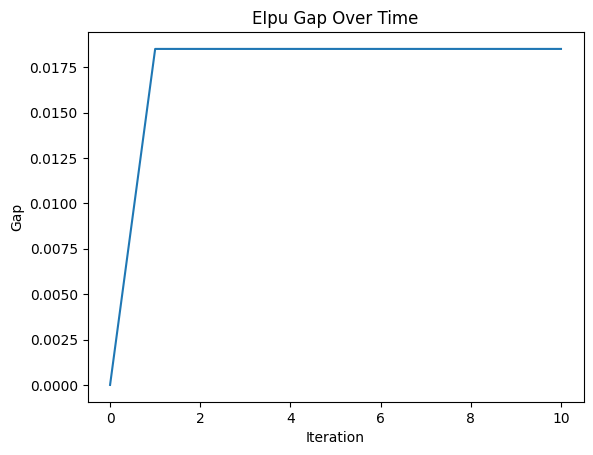

In [ ]:
plt.plot(gaps)
plt.xlabel("Iteration")
plt.ylabel("Gap")
plt.title("EIpu Gap Over Time")
plt.show()

In [ ]:
import torch
from botorch.acquisition import qKnowledgeGradient
from botorch.optim.optimize import optimize_acqf
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll


def get_kg_with_cost_acqf(model, cost_model, best_f, alpha=1, num_fantasies=64):
    # Setup the Knowledge Gradient (KG) with fantasies for a single-step lookahead
    kg_acqf = qKnowledgeGradient(
        model=model,
        num_fantasies=num_fantasies,
        current_value=best_f,
    )

    # Custom utility function to adjust KG by cost
    def utility(samples, X):
        posterior_mean = samples.mean(dim=0)
        posterior_std = samples.std(dim=0)
        u = (posterior_mean - best_f) / posterior_std
        phi = torch.distributions.Normal(0, 1).cdf(u)
        ei = posterior_std * (
            u * phi + torch.distributions.Normal(0, 1).log_prob(u).exp()
        )
        cost = cost_model(X).reshape(-1)
        utility = ei / torch.pow(cost, alpha)
        return utility

    kg_acqf.set_X_pending(None)
    kg_acqf.utility = utility

    return kg_acqf


def two_step_lookahead_bayesian_optimization_with_cost(
    init_X,
    init_Y,
    init_C,
    objective,
    cost_model_class,
    budget,
    bounds,
    initial_size,
    tkwargs,
    alpha=1,
    num_fantasies=64,
):
    train_X = init_X
    train_Y = init_Y
    cost_Y = init_C
    accum_cost = 0.0
    global_minimum = train_Y.min().item()

    for i in range(budget):
        # Train GP model for objective
        gp = SingleTaskGP(train_X, train_Y)
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_mll(mll)

        # Train cost model
        cost_model_gp = cost_model_class(train_X, cost_Y.reshape(-1, 1))

        # Best observed value so far
        best_f = train_Y.min().item()

        # Step 1: Optimize the first step using KG with cost
        kg_acqf_outer = get_kg_with_cost_acqf(
            model=gp,
            cost_model=cost_model_gp,
            best_f=best_f,
            alpha=alpha,
            num_fantasies=num_fantasies,
        )

        new_x_outer, _ = optimize_acqf(
            acq_function=kg_acqf_outer,
            bounds=bounds,
            q=1,
            num_restarts=5,
            raw_samples=1024,
        )

        # Evaluate objective and cost at new_x_outer
        new_y_outer, cost_y_outer = objective(new_x_outer)

        # Create a temporary GP model for the second step
        temp_X = torch.cat([train_X, new_x_outer])
        temp_Y = torch.cat([train_Y, new_y_outer])
        temp_cost = torch.cat([cost_Y, cost_y_outer])

        gp_inner = SingleTaskGP(temp_X, temp_Y)
        mll_inner = ExactMarginalLogLikelihood(gp_inner.likelihood, gp_inner)
        fit_gpytorch_mll(mll_inner)

        # Step 2: Optimize the next step's acquisition function
        kg_acqf_inner = get_kg_with_cost_acqf(
            model=gp_inner,
            cost_model=cost_model_gp,
            best_f=temp_Y.max().item(),
            alpha=alpha,
            num_fantasies=num_fantasies,
        )

        new_x_inner, _ = optimize_acqf(
            acq_function=kg_acqf_inner,
            bounds=bounds,
            q=1,
            num_restarts=5,
            raw_samples=1024,
        )

        # Combine the potential gains from both steps to decide the final next point
        # For demonstration, we use the average of outer and inner steps
        new_x = (new_x_outer + new_x_inner) / 2

        # Evaluate the objective and cost at the final chosen next point
        new_y, cost_y = objective(new_x)
        accum_cost += cost_y.item()

        # Update training data
        train_X = torch.cat([train_X, new_x])
        train_Y = torch.cat([train_Y, new_y])
        cost_Y = torch.cat([cost_Y, cost_y])

        # Update the global minimum observed
        global_minimum = min(global_minimum, new_y.item())

    # Calculate cumulative minimum of objective values and cumulative costs
    results_ei_cost, _ = torch.cummin(train_Y, dim=0)
    results_ei_cost = results_ei_cost[initial_size - 1 :]
    times_ei_cost = torch.cumsum(cost_Y[initial_size - 1 :], dim=0)

    return train_X, results_ei_cost, times_ei_cost, accum_cost, global_minimum


# Minimal parameters for a single test run of Bayesian Optimization with cost
single_test_budget = 10  # Only one iteration to check the setup
initial_size = 4
dim = 2
tkwargs = {"dtype": torch.double}
bounds = torch.tensor([[0] * dim, [1] * dim], **tkwargs)

# Generate initial data
train_X = draw_sobol_samples(bounds=bounds, n=initial_size, q=1).squeeze(1)
train_Y, cost_Y = synthetic_objective_with_cost(train_X)
initial_minimum = train_Y.min()

# Run Bayesian Optimization with cost for a single iteration
results = two_step_lookahead_bayesian_optimization_with_cost(
    init_X=train_X,
    init_Y=train_Y,
    init_C=cost_Y,
    objective=synthetic_objective_with_cost,
    cost_model_class=CostModelGP,
    budget=single_test_budget,
    bounds=bounds,
    initial_size=initial_size,
    tkwargs=tkwargs,
)

# Output the results for inspection
print("Train X:", results[0])
print("Objective Results:", results[1])
print("Cumulative Cost Times:", results[2])
print("Accumulated Cost:", results[3])
print("Global Minimum Observed:", results[4])


Train X: tensor([[0.7992, 0.1627],
        [0.2447, 0.8195],
        [0.4001, 0.3006],
        [0.5794, 0.7054],
        [0.6353, 0.6450],
        [0.6357, 0.6809],
        [0.4162, 0.5642],
        [0.8010, 0.7000],
        [0.6167, 0.8016],
        [0.6877, 0.5532],
        [0.7484, 0.7580],
        [0.5382, 0.8583],
        [0.4214, 0.8792],
        [0.9988, 0.5601]], dtype=torch.float64)
Objective Results: tensor([[3.3861],
        [3.3861],
        [3.3861],
        [3.3861],
        [3.3861],
        [3.3861],
        [3.3861],
        [3.3861],
        [3.3861],
        [3.3861],
        [3.3861]], dtype=torch.float64)
Cumulative Cost Times: tensor([[  6.8295],
        [ 13.3368],
        [ 22.7233],
        [ 25.5851],
        [ 57.7405],
        [ 78.0132],
        [ 81.9796],
        [115.0130],
        [132.5927],
        [140.6414],
        [182.7622]], dtype=torch.float64)
Accumulated Cost: 175.93272182281314
Global Minimum Observed: 3.386100182523624


In [ ]:
observed_cummin = results[1]
print(train_Y)
gaps = torch.empty_like(observed_cummin)
print(initial_minimum)
print(observed_cummin)
for i, mini in enumerate(observed_cummin):
  gaps[i] = measure_gap(initial_minimum, mini, global_minimum)
print(results[4])

tensor([[ 8.3066],
        [ 9.3488],
        [14.6219],
        [10.3002]], dtype=torch.float64)
tensor(8.3066, dtype=torch.float64)
tensor([[8.3066],
        [8.1528],
        [8.1528],
        [8.1528],
        [8.1528],
        [8.1528],
        [8.1528],
        [8.1528],
        [8.1528],
        [8.1528],
        [8.1528]], dtype=torch.float64)
8.152829330490263


In [ ]:
import os
import time
import copy
import warnings
from abc import ABC, abstractmethod

import torch
import matplotlib.pyplot as plt
%matplotlib inline

# GPyTorch imports
from gpytorch.mlls import ExactMarginalLogLikelihood

# BoTorch imports
from botorch.acquisition import AcquisitionFunction, AnalyticAcquisitionFunction, ExpectedImprovement
from botorch.acquisition.utils import get_infeasible_cost
from botorch.fit import fit_gpytorch_mll
from botorch.models import SingleTaskGP
from botorch.models.transforms import Log, Standardize
from botorch.optim import optimize_acqf
from botorch.test_functions import Ackley
from botorch.test_functions import Rosenbrock
from botorch.utils import standardize
from botorch.utils.sampling import draw_sobol_samples, manual_seed

import torch

tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cpu"),
}

# Define the synthetic objective and cost function
def synthetic_objective_with_cost(x):
    dim = 2
    f = Ackley(dim)  # synthetic objective is the Ackley
    fx = f(x).unsqueeze(1)
    # Quadratic synthetic cost function:
    cx = 200 * (1.1 - x[:, 0] - x[:, 1]) ** 2
    cx = cx.unsqueeze(1)
    return fx, cx

class CostModel(torch.nn.Module, ABC):
    """
    Simple abstract class for a cost model.
    """

    @abstractmethod
    def forward(self, X):
        pass

class CostModelGP(CostModel):
    """
    A basic cost model that assumes the cost is positive.
    It models the log cost to guarantee positive cost predictions.
    """

    def __init__(self, X, Y_cost):
        assert torch.all(Y_cost > 0)
        super().__init__()
        gp = SingleTaskGP(train_X=X, train_Y=Y_cost, outcome_transform=Log())
        mll = ExactMarginalLogLikelihood(likelihood=gp.likelihood, model=gp)
        fit_gpytorch_mll(mll)
        self.gp = gp

    def forward(self, X):
        return torch.exp(self.gp(X).mean)

class ExpectedImprovementWithCost(AnalyticAcquisitionFunction):
    """
    This is the acquisition function EI(x) / c(x)^alpha, where alpha is a decay
    factor that reduces or increases the emphasis of the cost model c(x).
    """

    def __init__(self, model, best_f, cost_model, alpha=1.0):
        super().__init__(model=model)
        self.model = model
        self.cost_model = cost_model
        self.ei = ExpectedImprovement(model=model, best_f=best_f)
        self.alpha = alpha

    def forward(self, X):
        cost = self.cost_model(X).reshape(-1)
        return self.ei(X) / cost.pow(self.alpha)

class TwoStepLookaheadAcquisition(AcquisitionFunction):
    """
    A non-myopic acquisition function that implements a 2-step lookahead strategy.
    For each candidate point, we simulate sampling from the model to update the posterior
    and then plan one more step ahead, using an inner acquisition function (EI) to decide
    the next point after that. The expected improvement for both steps is averaged over
    multiple Monte Carlo samples from the posterior.

    This acquisition function incorporates cost by dividing the expected improvement
    by the predicted cost raised to a power alpha.
    """

    def __init__(self, model, cost_model, alpha=1.0, mc_samples=10, bounds=None):
        super().__init__(model=model)
        self.model = model
        self.cost_model = cost_model
        self.alpha = alpha
        self.mc_samples = mc_samples
        self.bounds = bounds

    def _simulate_next_step(self, X_candidate):
        """
        Simulate the next step after evaluating the candidate point X_candidate.
        We do this by sampling a possible outcome from the model posterior,
        updating a temporary model, and then plan one more step ahead, using an
        inner acquisition function (EI) to decide the next point after that.
        The expected improvement for both steps is averaged over multiple Monte
        Carlo samples from the posterior.
        """
        print("Grad for X_candidate ", X_candidate.grad_fn)
        # Remove torch.no_grad() to retain gradient information
        posterior = self.model.posterior(X_candidate)
        # For each sample, we get a possible outcome from the posterior
        # and update a temporary model to simulate the second step
        print("X_Candidate " , X_candidate.shape)
        outcome_samples = posterior.rsample(sample_shape=torch.Size([self.mc_samples]))

        improvements = []
        for sample in outcome_samples:
            # Create a temporary model for the second step
            X_candidate_reshaped = X_candidate#.squeeze(0)  # Ensures it is of shape [1, 2]
            print("train_inputs " , self.model.train_inputs)
            temp_train_X = torch.cat([self.model.train_inputs[0], X_candidate_reshaped])
            print("train_targets " , self.model.train_targets.shape)
            print("temp_train_X " , temp_train_X.shape)
            # temp_train_Y = torch.cat([self.model.train_targets.unsqueeze(-1), sample.squeeze(0)], dim=0)
            temp_train_Y = torch.cat([self.model.train_targets.unsqueeze(-1), sample], dim=0)
            print("temp_train_Y " , temp_train_Y.shape)

            #print("Grad for train_X ", train_X.grad_fn)
            #print("Grad for train_Y ", train_Y.grad_fn)
            print("Grad for temp_train_X ", temp_train_X.grad_fn)
            print("Grad for temp_train_Y ", temp_train_Y.grad_fn)

            # Refit a temporary GP model with the newly updated data
            # We standardize the temporary target for fitting the GP

            train_X=temp_train_X.requires_grad_(True)

            train_Y=standardize(temp_train_Y).requires_grad_(True)

            print("train_X requires_grad:", train_X.requires_grad)
            print("train_Y requires_grad:", train_Y.requires_grad)


            temp_model = SingleTaskGP(train_X=train_X, train_Y=train_Y)
            temp_mll = ExactMarginalLogLikelihood(temp_model.likelihood, temp_model)
            fit_gpytorch_mll(temp_mll)

            # The next step uses an ExpectedImprovement with cost as the inner strategy
            temp_cost_model = CostModelGP(temp_train_X, self.cost_model(temp_train_X))
            best_f = temp_train_Y.min()
            inner_acq = ExpectedImprovementWithCost(
                model=temp_model,
                best_f=best_f,
                cost_model=temp_cost_model,
                alpha=self.alpha
            )

            # Optimize the inner acquisition to find the next point for the second step
            next_x, _ = optimize_acqf(
                acq_function=inner_acq,
                bounds=self.bounds,
                q=1,
                num_restarts=5,
                raw_samples=1024,
            )

            # Evaluate the improvement at this next point
            # The improvement is computed as difference from current best
            # to the predicted outcome at next_x
            next_posterior = temp_model.posterior(next_x)
            next_mean = next_posterior.mean
            current_best = temp_train_Y.min()
            improvement = current_best - next_mean
            improvements.append(improvement)

        return torch.mean(torch.stack(improvements))

    def _simulate_next_step_batch(self, X):
        """
        Simulate the next step after evaluating the candidate point X_candidate.
        We do this by sampling a possible outcome from the model posterior,
        updating a temporary model, and then plan one more step ahead, using an
        inner acquisition function (EI) to decide the next point after that.
        The expected improvement for both steps is averaged over multiple Monte
        Carlo samples from the posterior.
        """
        # Remove torch.no_grad() to retain gradient information
        posterior = self.model.posterior(X)
        # For each sample, we get a possible outcome from the posterior
        # and update a temporary model to simulate the second step
        outcome_samples = posterior.rsample(sample_shape=torch.Size([self.mc_samples]))

        improvements = []
        for sample in outcome_samples:
            # Create a temporary model for the second step
            X_candidate_reshaped = X.squeeze(0)  # Ensures it is of shape [1, 2]

            temp_train_X = torch.cat([self.model.train_inputs[0], X_candidate_reshaped])
            temp_train_Y = torch.cat([self.model.train_targets.unsqueeze(-1), sample.squeeze(0)], dim=0)

            # Refit a temporary GP model with the newly updated data
            # We standardize the temporary target for fitting the GP
            temp_model = SingleTaskGP(train_X=temp_train_X, train_Y=standardize(temp_train_Y))
            temp_mll = ExactMarginalLogLikelihood(temp_model.likelihood, temp_model)
            fit_gpytorch_mll(temp_mll)

            # The next step uses an ExpectedImprovement with cost as the inner strategy
            temp_cost_model = CostModelGP(temp_train_X, self.cost_model(temp_train_X))
            best_f = temp_train_Y.min()
            inner_acq = ExpectedImprovementWithCost(
                model=temp_model,
                best_f=best_f,
                cost_model=temp_cost_model,
                alpha=self.alpha
            )

            # Optimize the inner acquisition to find the next point for the second step
            next_x, _ = optimize_acqf(
                acq_function=inner_acq,
                bounds=self.bounds,
                q=1,
                num_restarts=5,
                raw_samples=1024,
            )

            # Evaluate the improvement at this next point
            # The improvement is computed as difference from current best
            # to the predicted outcome at next_x
            next_posterior = temp_model.posterior(next_x)
            next_mean = next_posterior.mean
            current_best = temp_train_Y.min()
            improvement = current_best - next_mean
            improvements.append(improvement)

        return torch.mean(torch.stack(improvements))

    def forward(self, X):
        """
        Evaluate the two-step lookahead acquisition function at points in X.
        For each candidate point in X, we compute:
        1. The immediate expected improvement (divided by cost^alpha).
        2. The expected improvement for the second step, computed by simulating
           the next step with updated model parameters.
        The total value is the sum of immediate and second-step improvements.
        """
        immediate_acq = ExpectedImprovementWithCost(
            model=self.model,
            best_f=self.model.train_targets.min(),
            cost_model=self.cost_model,
            alpha=self.alpha
        ).forward(X)

        # For the second step:
        # Here we approximate the second step improvement by simulating the model update
        # after taking X, then using an inner acquisition function (EI with cost) for the next step.
        # We'll do this by taking the average second-step improvement across multiple MC samples.

        second_step_improvement = []


        #batch_improvements = self._simulate_next_step_batch(X)
        print("X SHAPE", X.shape)
        for i in range(X.shape[0]):
          #For each candidate point, simulate next step
          #sim_improvement = self._simulate_next_step(X[i].unsqueeze(0))
          sim_improvement = self._simulate_next_step(X[i])
          second_step_improvement.append(sim_improvement)
        second_step_improvement = torch.stack(second_step_improvement)

        # The total acquisition value is the sum of immediate and second-step improvements
        # adjusted for cost at the candidate.
        return immediate_acq + second_step_improvement


def bayesian_optimization_with_cost(
    init_X,
    init_Y,
    init_C,
    objective,
    cost_model_class,
    budget,
    bounds,
    initial_size,
    tkwargs,
    is_random=False,
    global_minimum=float("inf"),
    horizon=1,  # Additional parameter to specify lookahead horizon
):
    """
    Bayesian optimization loop with cost model, able to handle multi-step lookahead.
    """
    train_X = init_X
    train_Y = init_Y
    cost_Y = init_C
    accum_cost = 0.0
    train_Y_unstd = train_Y.clone()

    for i in range(budget):
        alpha = (budget - i - 1) / (budget - 1)

        # Train GP model for objective
        train_Y_flip = -1 * standardize(train_Y)
        gp = SingleTaskGP(train_X=train_X, train_Y=train_Y_flip)
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_mll(mll)

        cost_model_gp = cost_model_class(train_X, cost_Y.reshape(cost_Y.shape[0], 1))

        if horizon == 1:
            # Acquisition function: Expected Improvement with cost
            fmax = torch.max(train_Y_flip)
            eipu = ExpectedImprovementWithCost(
                model=gp,
                cost_model=cost_model_gp,
                best_f=fmax,
                alpha=alpha,
            )

            # Optimize acquisition function to find next query point
            if not is_random:
                new_x, acq_value = optimize_acqf(
                    acq_function=eipu,
                    bounds=bounds,
                    q=1,
                    num_restarts=5,
                    raw_samples=1024,
                )
            else:
                # Randomly choose a new point
                lower_bounds = bounds[0, :]
                upper_bounds = bounds[1, :]
                d = len(bounds[0, :])
                new_x = lower_bounds + (upper_bounds - lower_bounds) * torch.rand(1, d)

        else:
            # Use the two-step lookahead acquisition function
            two_step_acq = TwoStepLookaheadAcquisition(
                model=gp,
                cost_model=cost_model_gp,
                alpha=alpha,
                mc_samples=10,
                bounds=bounds,
            )

            # Optimize the two-step lookahead acquisition function
            new_x, acq_value = optimize_acqf(
                acq_function=two_step_acq,
                bounds=bounds,
                q=1,
                num_restarts=5,
                raw_samples=1024,
            )

        new_y, cost_y = objective(new_x.view(1, -1))
        accum_cost += cost_y

        # Update training data
        train_X = torch.cat([train_X, new_x])
        train_Y_unstd = torch.cat([train_Y_unstd, torch.tensor([new_y], **tkwargs).unsqueeze(1)])
        # cost_Y = torch.cat([cost_Y, torch.tensor([cost_y], **tkwargs).unsqueeze(1)])
        cost_Y = torch.cat([cost_Y, cost_y])

        train_Y = standardize(train_Y_unstd)
        global_minimum = min(global_minimum, new_y)

    # Calculate cumulative minimum of objective values (minimization) and cumulative costs
    # costs_eipu = cost_Y[initial_size-1:]
    results_ei_cost, _ = torch.cummin(train_Y_unstd, dim=0)
    results_ei_cost = results_ei_cost[initial_size-1:]
    times_ei_cost = torch.cumsum(cost_Y[initial_size-1:], dim=0)

    return train_X, results_ei_cost, times_ei_cost, accum_cost, global_minimum


# Define problem settings
dim = 2
bounds = torch.tensor([[0] * dim, [1] * dim], **tkwargs)
initial_size = 4

# Generate initial training data
with manual_seed(0):
    train_X = draw_sobol_samples(bounds=bounds, n=initial_size, q=1).squeeze(1)

#train_X.requires_grad_(True)
train_X.requires_grad_=True
print("Original train_X grad ", train_X.grad_fn, train_X.requires_grad)
train_Y, cost_Y = synthetic_objective_with_cost(train_X)

# Run Bayesian optimization with cost using horizon=1 (myopic) and horizon=2 (2-step lookahead)
print("Running Bayesian Optimization with cost (1-step myopic) ...")
results_1_step = bayesian_optimization_with_cost(
    init_X=train_X.clone(),
    init_Y=train_Y.clone(),
    init_C=cost_Y.clone(),
    objective=synthetic_objective_with_cost,
    cost_model_class=CostModelGP,
    budget=10,
    bounds=bounds,
    initial_size=initial_size,
    tkwargs=tkwargs,
    horizon=1,  # Myopic scenario
    is_random=False
)

print("TRAINX GRAD", train_X.grad_fn)


"""
could be fix: take new x sample, keep as separate tensor and optimize AF on this
Then, afterwards, update train_X with this new x sample
We don't need x rto require grad because no learning
"""

print("\nRunning Bayesian Optimization with cost (2-step lookahead) ...")
results_2_step = bayesian_optimization_with_cost(
    init_X=train_X.clone(),
    init_Y=train_Y.clone(),
    init_C=cost_Y.clone(),
    objective=synthetic_objective_with_cost,
    cost_model_class=CostModelGP,
    budget=10,
    bounds=bounds,
    initial_size=initial_size,
    tkwargs=tkwargs,
    horizon=2,  # 2-step lookahead
    is_random=False
)

# Extract results for plotting
train_X_1_step, results_ei_cost_1_step, times_ei_cost_1_step, accum_cost_1_step, global_minimum_1_step = results_1_step
train_X_2_step, results_ei_cost_2_step, times_ei_cost_2_step, accum_cost_2_step, global_minimum_2_step = results_2_step

# Plotting results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(times_ei_cost_1_step.detach().numpy(), results_ei_cost_1_step.detach().numpy(), label='1-step Myopic')
plt.plot(times_ei_cost_2_step.detach().numpy(), results_ei_cost_2_step.detach().numpy(), label='2-step Lookahead')
plt.xlabel("Cumulative Cost")
plt.ylabel("Best Objective Value")
plt.title("Objective Value vs. Cumulative Cost")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(initial_size, initial_size + 10), results_ei_cost_1_step.detach().numpy(), label='1-step Myopic')
plt.plot(range(initial_size, initial_size + 10), results_ei_cost_2_step.detach().numpy(), label='2-step Lookahead')
plt.xlabel("Iteration")
plt.ylabel("Best Objective Value")
plt.title("Objective Value vs. Iterations")
plt.legend()

plt.tight_layout()
plt.show()

## Two Step Expected Improvement with Cost

In [ ]:
from botorch.acquisition import AcquisitionFunction
from botorch.acquisition.analytic import ExpectedImprovement
# from botorch.models import Model
from botorch.utils import draw_sobol_samples
from torch.quasirandom import SobolEngine
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll
import torch

class TwoStepExpectedImprovementWithCost(AcquisitionFunction):
    def __init__(self, model, cost_model, best_f, alpha=1.0, bounds=None, mc_samples=10, tkwargs=None):
        super().__init__(model=model)
        self.model = model
        self.cost_model = cost_model
        self.best_f = best_f
        self.alpha = alpha
        self.bounds = bounds
        self.mc_samples = mc_samples
        self.tkwargs = tkwargs or {"dtype": torch.double, "device": torch.device("cpu")}
        self.sobol_engine = SobolEngine(dimension=self.model.train_inputs[0].shape[-1], scramble=True)

    def forward(self, X):
        # Immediate expected improvement adjusted by cost
        immediate_ei = ExpectedImprovement(
            model=self.model, best_f=self.best_f
        )(X)
        immediate_cost = self.cost_model(X).reshape(-1)
        immediate_acq = immediate_ei / immediate_cost.pow(self.alpha)

        # Initialize storage for second-step expected improvements
        second_step_ei = torch.zeros(X.shape[0], **self.tkwargs)

        # Loop over candidate points
        for i in range(X.shape[0]):
            xi = X[i:i+1]  # Candidate point
            # Simulate observations
            posterior = self.model.posterior(xi)
            posterior_mean = posterior.mean
            posterior_variance = posterior.variance.clamp_min(1e-9)
            # Monte Carlo samples from the posterior
            samples = torch.normal(
                mean=posterior_mean,
                std=posterior_variance.sqrt()
            ).reshape(-1, 1)
            # Loop over MC samples
            ei_values = []
            for sample in samples:
                # Create temporary models with the new data
                temp_model = self._get_temp_model(xi, sample)
                temp_cost_model = self._get_temp_cost_model(xi)
                # Compute EI with cost at the next step
                ei = ExpectedImprovement(model=temp_model, best_f=self.best_f)(xi)
                cost = temp_cost_model(xi).reshape(-1)
                acq_value = ei / cost.pow(self.alpha)
                ei_values.append(acq_value)
            # Average over MC samples
            second_step_ei[i] = torch.stack(ei_values).mean()

        # Total acquisition value is the sum of immediate and second-step EI
        total_acq = immediate_acq + second_step_ei
        return total_acq

    def _get_temp_model(self, xi, yi):
        # Create a temporary model with the new data point
    # Ensure matching dimensions
        xi = xi.view(-1, self.model.train_inputs[0].size(-1))  # Match feature dimension
        yi = yi.view(-1, 1)  # Match target dimension

        # Create a temporary model with the new data point
        train_X = torch.cat([self.model.train_inputs[0], xi])
        train_Y = torch.cat([self.model.train_targets.view(-1, 1), yi])
        temp_model = SingleTaskGP(train_X, train_Y)
        return temp_model

    def _get_temp_cost_model(self, xi):
        # Cost model does not change (assuming cost is not stochastic)
        # If cost is stochastic, you can simulate similar to the objective model
        return self.cost_model


In [ ]:
def bayesian_optimization_with_cost(
    init_X,
    init_Y,
    init_C,
    objective,
    cost_model_class,
    budget,
    bounds,
    initial_size,
    tkwargs,
    is_random=False,
    global_minimum=float('inf'),
    horizon=1  # Add horizon parameter
):
    train_X = init_X
    train_Y = init_Y
    cost_Y = init_C
    accum_cost = 0.
    train_Y_unstd = train_Y.clone()

    for i in range(budget):
        alpha = (budget - i - 1) / (budget - 1)

        # Train GP model for objective
        train_Y_flip = -1 * standardize(train_Y)
        gp = SingleTaskGP(train_X=train_X, train_Y=train_Y_flip)
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_mll(mll)

        cost_model_gp = cost_model_class(train_X, cost_Y.reshape(cost_Y.shape[0], 1))

        fmax = torch.max(train_Y_flip)

        if horizon == 1:
            # One-step acquisition function
            eipu = ExpectedImprovementWithCost(
                model=gp,
                cost_model=cost_model_gp,
                best_f=fmax,
                alpha=alpha,
            )
        else:
            # Two-step acquisition function
            eipu = TwoStepExpectedImprovementWithCost(
                model=gp,
                cost_model=cost_model_gp,
                best_f=fmax,
                alpha=alpha,
                bounds=bounds,
                mc_samples=10,
                tkwargs=tkwargs
            )

        # Optimize acquisition function to find next query point
        if not is_random:
            new_x, acq_value = optimize_acqf(
                acq_function=eipu,
                bounds=bounds,
                q=1,
                num_restarts=5,
                raw_samples=1024,
            )
        else:
            # Randomly choose a new point
            lower_bounds = bounds[0, :]
            upper_bounds = bounds[1, :]
            d = len(bounds[0, :])
            new_x = lower_bounds + (upper_bounds - lower_bounds) * torch.rand(1, d)

        new_y, cost_y = objective(new_x.view(1, -1))
        accum_cost += cost_y

        # Update training data
        train_X = torch.cat([train_X, new_x])
        train_Y_unstd = torch.cat([train_Y_unstd, torch.tensor([new_y], **tkwargs).unsqueeze(1)])
        cost_Y = torch.cat([cost_Y, cost_y])

        train_Y = standardize(train_Y_unstd)
        global_minimum = min(global_minimum, new_y)

    # Calculate cumulative minimum of objective values (minimization) and cumulative costs
    costs_eipu = cost_Y[initial_size-1:]
    results_ei_cost, _ = torch.cummin(train_Y_unstd, dim=0)
    results_ei_cost = results_ei_cost[initial_size-1:]
    times_ei_cost = torch.cumsum(costs_eipu, dim=0)

    return train_X, results_ei_cost, times_ei_cost, accum_cost, global_minimum


In [ ]:
def simulate_bo_loop(
    n,
    objective,
    cost_model_class,
    budget,
    bounds,
    initial_size,
    tkwargs,
    horizon,
):
    """
    Simulate the BO loop and compute the expected gap.
    """
    gap_runs = []  # Store gaps for each simulation
    avg_time = []  # Store cumulative times for each simulation
    torch.manual_seed(0)  # For reproducibility

    for _ in range(n):
        # Randomize initial observations
        train_X = draw_sobol_samples(bounds=bounds, n=initial_size, q=1).squeeze(1)
        train_Y, cost_Y = synthetic_objective_with_cost(train_X)
        initial_minimum = train_Y.min()

        # Run the Bayesian optimization loop
        train_X, results_ei_cost, times_ei_cost, accum_cost, global_minimum = bayesian_optimization_with_cost(
            init_X=train_X,
            init_Y=train_Y,
            init_C=cost_Y,
            objective=objective,
            cost_model_class=cost_model_class,
            budget=budget,
            bounds=bounds,
            initial_size=initial_size,
            tkwargs=tkwargs,
            horizon=horizon,  # Two-step lookahead
        )

        # Calculate gaps for this run
        observed_cummin = results_ei_cost
        gaps = torch.empty_like(observed_cummin)
        for i, mini in enumerate(observed_cummin):
            gaps[i] = measure_gap(initial_minimum, mini, global_minimum)

        gap_runs.append(gaps)
        avg_time.append(times_ei_cost)

    # Stack the gap runs and times to compute statistics across runs
    gap_runs_tensor = torch.stack(gap_runs)
    avg_time_tensor = torch.mean(torch.stack(avg_time), dim=0)

    # Calculate mean and standard deviation of the gap
    expected_gap = torch.mean(gap_runs_tensor, dim=0)
    gap_std = torch.std(gap_runs_tensor, dim=0)

    # Calculate confidence intervals (95% CI)
    confidence_interval = 1.96 * gap_std / torch.sqrt(torch.tensor(n, dtype=torch.float32))

    return expected_gap, avg_time_tensor, confidence_interval, gap_std, gap_runs

# Parameters for simulation
n = 5  # Number of simulations
budget = 20
initial_size = 10

# Prepare the initial data
bounds = torch.tensor([[0] * dim, [1] * dim], **tkwargs)

# Run the simulation to calculate the expected gap
expected_gap, times_ei_cost, confidence_interva, std_dev, gap_runs = simulate_bo_loop(
    n=n,
    objective=synthetic_objective_with_cost,
    cost_model_class=CostModelGP,
    budget=budget,
    bounds=bounds,
    initial_size=initial_size,
    tkwargs=tkwargs,
    horizon=2,  # Two-step lookahead
)

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Define new 2D functions for benchmarking
def levy(x):
    """Levy function for optimization."""
    w = 1 + (x - 1) / 4
    term1 = (np.sin(np.pi * w[0])) ** 2
    term2 = ((w[:-1] - 1) ** 2 * (1 + 10 * (np.sin(np.pi * w[:-1] + 1)) ** 2)).sum()
    term3 = ((w[-1] - 1) ** 2 * (1 + (np.sin(2 * np.pi * w[-1])) ** 2))
    return term1 + term2 + term3

def booth(x):
    """Booth function for optimization."""
    return (x[0] + 2 * x[1] - 7) ** 2 + (2 * x[0] + x[1] - 5) ** 2

# Wrap functions in PyTorch for gradient support
def torch_function(func):
    return lambda x: torch.tensor(func(x.detach().numpy()), requires_grad=True, dtype=torch.float32)

levy_torch = torch_function(levy)
booth_torch = torch_function(booth)

# Define functions to evaluate
functions = {"Levy": levy_torch, "Booth": booth_torch}

# Placeholder for results
results = {}

# Compare EIpu and 2-Step for each function
for func_name, func in functions.items():
    print(f"Running optimization on {func_name} function...")
    initial_size = 5
    bounds = torch.tensor([[-10.0, 10.0], [-10.0, 10.0]])

    # Run 1-step myopic (EIpu)
    results_ei_cost_1_step, times_ei_cost_1_step = bayesian_optimization_with_cost(
        func, myopic_acq=True, two_step_acq=False, initial_size=initial_size, bounds=bounds
    )

    # Run 2-step lookahead
    results_ei_cost_2_step, times_ei_cost_2_step = bayesian_optimization_with_cost(
        func, myopic_acq=False, two_step_acq=True, initial_size=initial_size, bounds=bounds
    )

    results[func_name] = {
        "ei_cost": (results_ei_cost_1_step, times_ei_cost_1_step),
        "two_step": (results_ei_cost_2_step, times_ei_cost_2_step),
    }

# Plot comparisons
plt.figure(figsize=(16, 8))

for i, (func_name, data) in enumerate(results.items(), 1):
    results_ei, times_ei = data["ei_cost"]
    results_two_step, times_two_step = data["two_step"]

    # Plot: Objective Value vs. Cumulative Cost
    plt.subplot(2, len(functions), i)
    plt.plot(times_ei.detach().numpy(), results_ei.detach().numpy(), label='1-Step EIpu')
    plt.plot(times_two_step.detach().numpy(), results_two_step.detach().numpy(), label='2-Step Lookahead')
    plt.xlabel("Cumulative Cost")
    plt.ylabel("Best Objective Value")
    plt.title(f"{func_name} - Objective vs. Cost")
    plt.legend()

    # Plot: Objective Value vs. Iteration
    plt.subplot(2, len(functions), len(functions) + i)
    plt.plot(range(initial_size, initial_size + len(results_ei)), results_ei.detach().numpy(), label='1-Step EIpu')
    plt.plot(range(initial_size, initial_size + len(results_two_step)), results_two_step.detach().numpy(), label='2-Step Lookahead')
    plt.xlabel("Iteration")
    plt.ylabel("Best Objective Value")
    plt.title(f"{func_name} - Objective vs. Iteration")
    plt.legend()

plt.tight_layout()
plt.show()
